<a href="https://colab.research.google.com/github/gcalanch/DMA-Caras/blob/main/isomap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reducción de Dimensionalidad a partir del Preprocesamiento y Aumentacion

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
import shutil
from pathlib import Path
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.manifold import Isomap
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from PIL import Image
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import polars as pl
import joblib

Fusion de datos de caras

In [ ]:
# Rutas origen
origenes = ["/content/drive/MyDrive/DMA/Aumentadas21", "/content/drive/MyDrive/DMA/Detectadas21"]

# Ruta destino
ruta_destino = Path("/content/drive/MyDrive/DMA/Datos_Agrupados")
ruta_destino.mkdir(exist_ok=True)

# Recorrer ambas carpetas origen
for origen in origenes:
    ruta_origen = Path(origen)

    if not ruta_origen.exists():
        print(f"La carpeta {origen} no existe, asegúrate de subirla.")
        continue

    # Iterar por las subcarpetas (clases o categorías)
    for carpeta in ruta_origen.iterdir():
        if carpeta.is_dir():
            destino_categoria = ruta_destino / carpeta.name
            destino_categoria.mkdir(parents=True, exist_ok=True)

            # Copiar todos los archivos a la carpeta de destino
            for archivo in carpeta.iterdir():
                if archivo.is_file():
                    destino_archivo = destino_categoria / archivo.name
                    # Si ya existe un archivo con ese nombre, saltar este archivo
                    if not destino_archivo.exists():
                        shutil.copy2(archivo, destino_archivo)
                    else:
                        print(f"Archivo {archivo.name} ya existe en {destino_categoria}, saltando copia.")


print("Archivos fusionados correctamente en 'Datos_Agrupados'.")

Carga de Imagenes y Etiquetas

In [ ]:
ruta_entrada = "/content/drive/MyDrive/DMA/Datos_Agrupados"

imagenes = []
etiquetas = []

print("Cargando imágenes...")
for persona in os.listdir(ruta_entrada):
    ruta_persona = os.path.join(ruta_entrada, persona)
    if os.path.isdir(ruta_persona):
        for img in os.listdir(ruta_persona):
            if img.lower().endswith(('.png', '.jpg', '.jpeg')):
                ruta_imagen = os.path.join(ruta_persona, img)
                imagenes.append(ruta_imagen)
                etiquetas.append(persona)

print(f"Total de imágenes cargadas: {len(imagenes)}")
if imagenes:
    muestra = np.array(Image.open(imagenes[0]).convert('L'))
    print(f"Dimensión de cada imagen: {muestra.shape} (total features: {muestra.size})")

Cargando imágenes...
Total de imágenes cargadas: 3420
Dimensión de cada imagen: (80, 80) (total features: 6400)


Vectorizacion de Imagenes y reduccion con ISOMAP

In [ ]:
print("Vectorizando imágenes y aplicando reducción de dimensionalidad con Isomap...")
imagenes_vectorizadas = np.array([np.array(Image.open(img).convert('L')).flatten() for img in imagenes])


isomap = Isomap(n_neighbors=12, n_components=50)
imagenes_isomap = isomap.fit_transform(imagenes_vectorizadas)

print(f"Dimensión después de Isomap: {imagenes_isomap.shape}")

Vectorizando imágenes y aplicando reducción de dimensionalidad con Isomap...
Dimensión después de Isomap: (3420, 50)


Guarda Resultados

Definicion de rutas para guardar datos ISOMAP

In [ ]:
base_path = "/content/drive/MyDrive/DMA/Datos_ISOMAP"
ruta_csv = os.path.join(base_path, "datos_isomap.csv")
ruta_pkl_con_etiqueta = os.path.join(base_path, "datos_isomap_con_etiqueta.pkl")
ruta_pkl_sin_etiqueta = os.path.join(base_path, "datos_isomap_sin_etiqueta.pkl")
ruta_modelo_isomap = os.path.join(base_path, "modelo_isomap.pkl")

Guarda Resultados

In [ ]:
# Crea DataFrame Polars
columnas = [f'PC{i+1}' for i in range(imagenes_isomap.shape[1])]
df_polars = pl.DataFrame(imagenes_isomap, schema=columnas)
df_polars_con_etiqueta = df_polars.with_columns(pl.Series(name='Etiqueta', values=etiquetas))

# Guarda CSV
df_polars_con_etiqueta.write_csv(ruta_csv, separator='\t')
print(f"✅ Datos guardados correctamente en {ruta_csv}.")

# Guarda datos como .pkl
joblib.dump(df_polars_con_etiqueta, ruta_pkl_con_etiqueta)
print(f"✅ Datos con etiqueta guardados en {ruta_pkl_con_etiqueta}.")

joblib.dump(df_polars, ruta_pkl_sin_etiqueta)
print(f"✅ Datos sin etiqueta guardados en {ruta_pkl_sin_etiqueta}.")

# Guarda el modelo Isomap
joblib.dump(isomap, ruta_modelo_isomap)
print(f"✅ Modelo Isomap guardado en {ruta_modelo_isomap}.")

✅ Datos guardados correctamente en /content/drive/MyDrive/DMA/Datos_ISOMAP/datos_isomap.csv.
✅ Datos con etiqueta guardados en /content/drive/MyDrive/DMA/Datos_ISOMAP/datos_isomap_con_etiqueta.pkl.
✅ Datos sin etiqueta guardados en /content/drive/MyDrive/DMA/Datos_ISOMAP/datos_isomap_sin_etiqueta.pkl.
✅ Modelo Isomap guardado en /content/drive/MyDrive/DMA/Datos_ISOMAP/modelo_isomap.pkl.


# Analisis Clustering con DBSCAN

In [ ]:
print("Normalizando datos y aplicando DBSCAN...")
scaler = StandardScaler()
imagenes_isomap_scaled = scaler.fit_transform(imagenes_isomap)

dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(imagenes_isomap_scaled)

Normalizando datos y aplicando DBSCAN...


Visualizacion Clustering

Visualizando resultados del clustering...


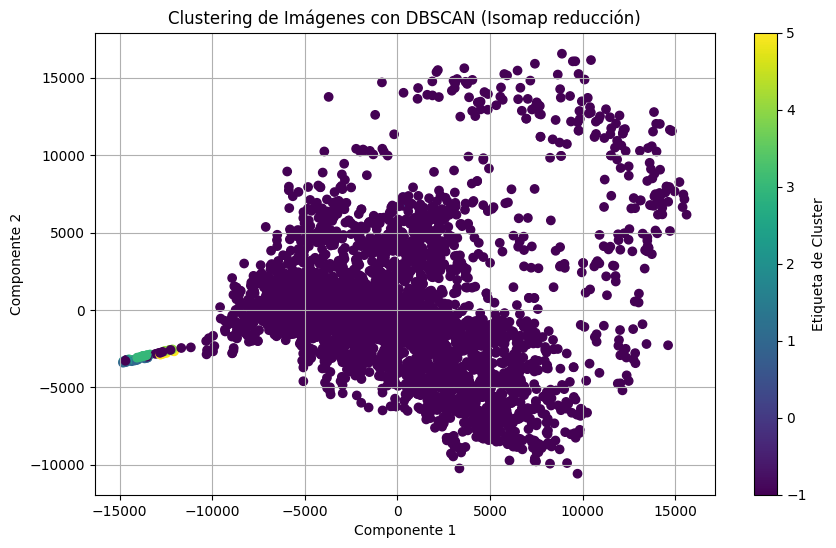

In [ ]:
print("Visualizando resultados del clustering...")

plt.figure(figsize=(10, 6))
plt.scatter(imagenes_isomap[:, 0], imagenes_isomap[:, 1], c=labels_dbscan, cmap='viridis', marker='o')
plt.title('Clustering de Imágenes con DBSCAN (Isomap reducción)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar(label='Etiqueta de Cluster')
plt.grid(True)
plt.show()

Visualización con etiquetas

Visualizando imágenes según etiquetas...


<ipython-input-15-041868499437>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('tab20', len(etiquetas_unicas))


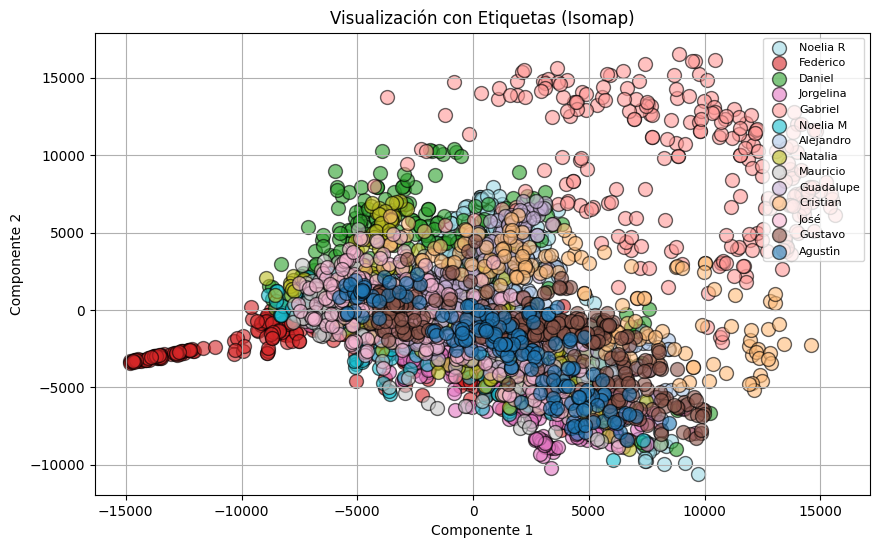

In [ ]:
print("Visualizando imágenes según etiquetas...")

etiquetas_unicas = sorted(set(etiquetas))
colormap = plt.cm.get_cmap('tab20', len(etiquetas_unicas))
colores = {et: colormap(i) for i, et in enumerate(etiquetas_unicas)}

plt.figure(figsize=(10, 6))
for i in range(len(imagenes_isomap)):
    x, y = imagenes_isomap[i, 0], imagenes_isomap[i, 1]
    plt.scatter(x, y, color=colores[etiquetas[i]], label=etiquetas[i], alpha=0.6, edgecolors='k', s=100)

# Eliminar etiquetas duplicadas en la leyenda
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(), loc='upper right', fontsize=8)
plt.title('Visualización con Etiquetas (Isomap)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.show()

Clustering Jerárquico

Aplicando clustering jerárquico...


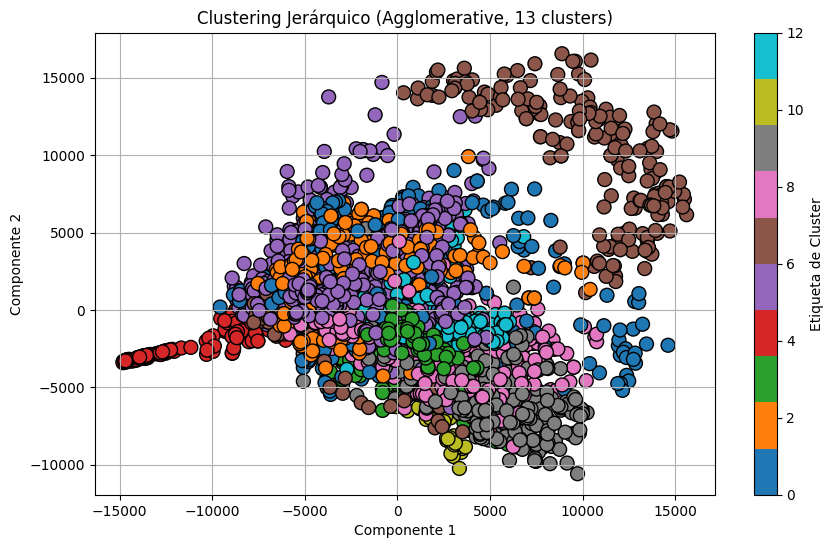

In [ ]:
print("Aplicando clustering jerárquico...")

# Aplicamos Agglomerative Clustering sobre los datos escalados
n_clusters = 13  # Se ajusta según los resultados que esperados
agglo = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
labels_agglo = agglo.fit_predict(imagenes_isomap_scaled)

# Visualización del clustering jerárquico en 2D
plt.figure(figsize=(10, 6))
plt.scatter(imagenes_isomap[:, 0], imagenes_isomap[:, 1], c=labels_agglo, cmap='tab10', s=100, edgecolors='k')
plt.title(f'Clustering Jerárquico (Agglomerative, {n_clusters} clusters)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.grid(True)
plt.colorbar(label='Etiqueta de Cluster')
plt.show()

Dendrograma

Generando dendrograma jerárquico...


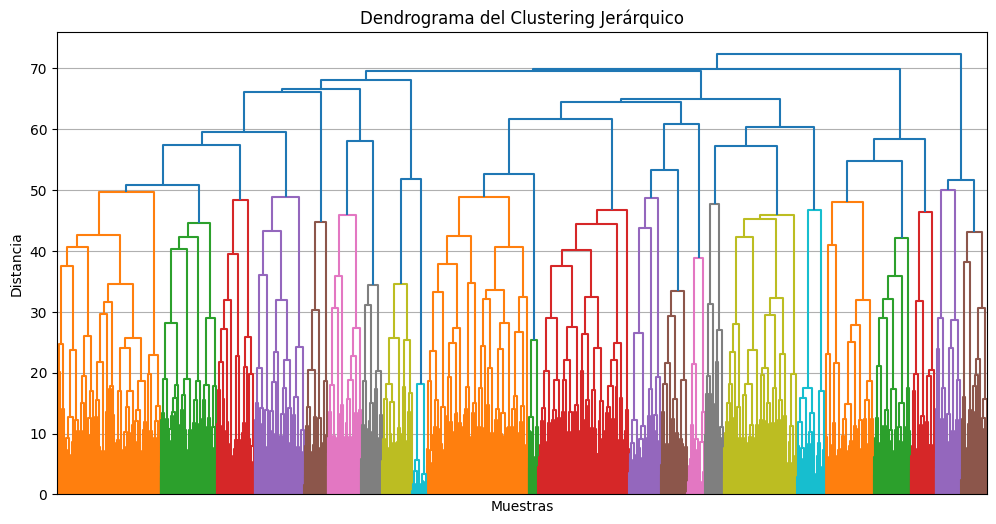

In [ ]:
print("Generando dendrograma jerárquico...")

linked = linkage(imagenes_isomap_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=False,
           no_labels=True)
plt.title('Dendrograma del Clustering Jerárquico')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.grid(True)
plt.show()